# **Flooding in Italy - working code (R)**

In [46]:
source("../methods_extRemes.r")

prep_window <- function(rc = c(1,1), w = 4, h = 4) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20) }
load_ts <- function(fnm, col.names) { read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = col.names) }

# parameters for confidence intervals
rp <- 100
nsamp <- 1000

In [2]:
# support function to give required results
mdl_ests <- function(mdl, cov, cov_cf, ev, rp = NA) {

    pars <- mdl$results$par
    disp <- unname(pars["sigma0"] / pars["mu0"])

    if(is.na(rp)) rp <- return_period(mdl, value = ev, covariate = cov, lower = F)
    if(is.finite(rp)) {
        rp_cf <- return_period(mdl, value = ev, covariate = cov_cf)
        rl_cf <- unname(return_level(mdl, rp = rp, covariate = cov_cf))

        c(pars,
          "disp" = disp, 
          "event_magnitude" = ev, 
          "return_period" = rp, 
          "PR" = rp_cf / rp, 
          "dI_abs" = ev - rl_cf, 
          "dI_rel" = (ev - rl_cf) / rl_cf * 100)
    } else {
        return(rep(NA, 10))
    }
}

In [3]:
# wrapper function to get bootstrapped confidence intervals for spreadsheet
boot_ci <- function(mdl, cov, cov_cf, ev = NA, rp = NA, seed = 42, nsamp = 500, dp = 5) {
    
    # get best estimate from the observed data
    if(is.na(ev)) ev  <- mdl$x[length(mdl$x)]
    mdl_res <- mdl_ests(mdl, cov, cov_cf, ev, rp = rp)
    mdl_df <- mdl$cov.data
    
    # get bootstrap sample
    set.seed(seed)    
    boot_res <- sapply(1:nsamp, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        tryCatch({
            boot_mdl <- fevd_fixeddisp("rx21day", "gmst", boot_df, solver = "Nelder-Mead")
            mdl_ests(boot_mdl, cov, cov_cf, ev, rp = rp)
        },
        error = function(cond) {return(rep(NA, 10))})
    })
    boot_qq <- t(rbind("bestimate" = mdl_res, apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)))
    if(!is.na(dp)) boot_qq <- round(boot_qq, dp)
    return(boot_qq)
}

In [4]:
model_results <- function(df, rp = 10, cov_pres, cov_pi, cov_fut, nsamp = 5, seed = 42) {
    
    # FUNCTION TO CARRY OUT ALL ATTRIBUTION RUNS & PRODUCE RESULTS IN SPREADSHEET-FRIENDLY FORM
    
    set.seed(seed)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # FIT MODEL to three different subsets: for evaluation, attribution & projection
    
    # fit models
    mdl_eval <- fevd_fixeddisp("rx21day", "gmst", df[df$year >= 1979 & df$year <= 2023,], solver = "Nelder-Mead")
    mdl_attr <- fevd_fixeddisp("rx21day", "gmst", df[df$year <= 2023,], solver = "Nelder-Mead")
    mdl_proj <- fevd_fixeddisp("rx21day", "gmst", df[df$year <= 2050,], solver = "Nelder-Mead")
    
    # get return level to use for analysis
    event_rl <- unname(return_level(mdl_attr, rp = rp, covariate = cov_pres))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## Bootstrap each set of model results

    ci_eval <- boot_ci(mdl_eval, cov = cov_pres, cov_cf = cov_pi, ev = event_rl, rp = rp, nsamp = nsamp)[c("disp", "shape"),]
    ci_attr <- boot_ci(mdl_attr, cov = cov_pres, cov_cf = cov_pi, ev = event_rl, rp = rp, nsamp = nsamp)[c("PR", "dI_rel"),]
    ci_proj <- boot_ci(mdl_proj, cov = cov_pres, cov_cf = cov_fut, ev = event_rl, rp = rp, nsamp = nsamp)[c("PR", "dI_rel"),]
                   
    # invert future projections
    ci_proj["PR",] <- 1/ci_proj["PR",c(1,3,2)]
    ci_proj["dI_rel",] <- -ci_proj["dI_rel", c(1,3,2)]
    
    # flatten & rename
    ci_eval <- unlist(lapply(rownames(ci_eval), function(cnm) setNames(ci_eval[cnm,], paste("eval", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    ci_attr <- unlist(lapply(rownames(ci_attr), function(cnm) setNames(ci_attr[cnm,], paste("attr", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    ci_proj <- unlist(lapply(rownames(ci_proj), function(cnm) setNames(ci_proj[cnm,], paste("proj", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
                         
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    t(data.frame(c(ci_eval, "rp_value" = event_rl, ci_attr, ci_proj)))     
}

---
## **Trend analysis - observations**

In [54]:
# load GMST data, shift GMST to be zero at present climate
gmst <- load_ts("ts/Italy-floods_gmst-smoothed.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

In [55]:
gmst_2023 <- gmst[gmst$year == 2023, "gmst"]
gmst_cf <- gmst_2023 - 1.2

### **MSWEP**

In [56]:
df <- merge(gmst, load_ts("ts/Italy-floods_rx21day-amj_mswep.dat", col.names = c("year", "rx21day")))
pr_2023 <- df$rx21day[df$year == 2023]

In [57]:
# results for spreadsheet
ns_mdl <- fevd_fixeddisp("rx21day", "gmst", df, solver = "Nelder-Mead")
# boot_res <- boot_ci(ns_mdl, gmst_2023, gmst_cf, nsamp = 1000)
# write.csv(boot_res, "res/res_Italy-floods_rx21day-amj_mswep.csv")

In [58]:
# confidence interval for location
set.seed(42)
loc_ci <- apply(sapply(1:1000, function(n) {
    boot_df <- ns_mdl$cov.data[sample(nrow(ns_mdl$cov.data), replace = T),]
    boot_mdl <- fevd_fixeddisp("rx21day", "gmst", boot_df, solver = "Nelder-Mead")
    c("f" = sgev_pars(boot_mdl, gmst_2023)$loc, "cf" = sgev_pars(boot_mdl, gmst_cf)$loc)
}), 1, quantile, c(0.025,0.975))

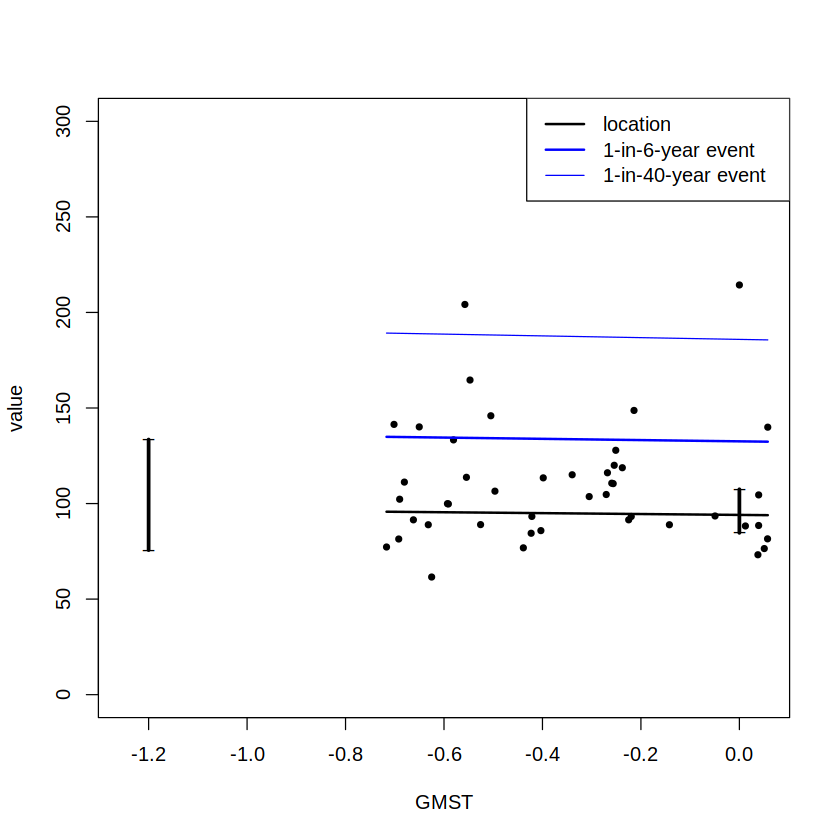

In [59]:
# GMST trend plots
plot_gmsttrend(ns_mdl, ylim = c(0,300), xlim = c(-1.25,0.05))
lines(rep(gmst_2023, 2), loc_ci[,"f"], lwd = 3, type = "o", pch = "_")
lines(rep(gmst_cf, 2), loc_ci[,"cf"], lwd = 3, type = "o", pch = "_")

In [60]:
plot_returnperiods(ns_mdl, cov1 = gmst_2023, cov2 = gmst_cf, lower = F, event_value = pr_2023, ylim = c(0,500))

In [9]:
# ERA5
df <- merge(gmst, load_ts("ts/Italy-floods_rx21day-amj_era5.dat", col.names = c("year", "rx21day")))
ns_mdl <- fevd_fixeddisp("rx21day", "gmst", df, solver = "Nelder-Mead")
boot_res <- boot_ci(ns_mdl, gmst_2023, gmst_cf, nsamp = 1000)
write.csv(boot_res, "res/res_Italy-floods_rx21day-amj_era5.csv")

## **Trend analysis - CORDEX**

In [6]:
# loop over all available models, get results for each
invisible(sapply(list.files("ts", pattern = "rx21day-amj_EUR-11", full.names = T), function(fnm) {

    res_fnm <- paste0("res/res_",gsub("ts/", "", gsub(".dat", "", fnm)), ".csv")
    print(fnm)
    if(!file.exists(res_fnm)) {
        
        # load data   
        gmst_fnm <- list.files("ts", paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4], "_rcp85_", strsplit(fnm, "_")[[1]][5], ".dat"), full.names = T)
        df <- merge(load_ts(gmst_fnm, col.names = c("year", "gmst")), 
                    load_ts(fnm, col.names = c("year", "rx21day")))
        
        gmst_2023 <- df[df$year == 2023, "gmst"]
        gmst_pi <- gmst_2023 - 1.2
        gmst_fut <- gmst_2023 + 0.8

        res_df <- model_results(df, rp = rp, gmst_2023, gmst_pi, gmst_fut, nsamp = nsamp)
        rownames(res_df) <- gsub(".dat", "", paste0(strsplit(fnm, "_")[[1]][4:6], collapse = "_"))

        write.csv(res_df, res_fnm)
    }
}))

[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_ALADIN53.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_ALADIN63.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_ALARO-0.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_CCLM4-8-17.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_crCLIM-v1-1.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_HadREM3-GA7-05.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_RACMO22E.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_RCA4.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_RegCM4-6.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_REMO2015.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_WRF381P.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_EC-EARTH_r1_crCLIM-v1-1.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_EC-EARTH_r1_RACMO22E.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_EC-EARTH_r1_RCA4.dat"
[1] "ts/Italy-floods_rx21day-amj_EUR-11_EC-EARTH_r12_CCLM4-8-17.dat"
[1]

In [8]:
# compile into single file 
res <- do.call("rbind", sapply(list.files("res", pattern = "EUR-11", full.names = T), read.csv, row.names = 1, simplify = F))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][5:7], collapse = "_")))
write.csv(res, "Italy-floods_cordex-results.csv")

## **Trend analysis - UKCP**

In [5]:
# loop over all available models, get results for each
invisible(sapply(list.files("ts", pattern = "rx21day-amj_UKCP18", full.names = T), function(fnm) {
    
    ens <- gsub(".dat", "", gsub(".+_", "", fnm))
    res_fnm <- paste0("res/res_",gsub("ts/", "", gsub(".dat", "", fnm)), ".csv")
    print(fnm)
    if(!file.exists(res_fnm)) {
        
        # load data   
        gmst_fnm <- list.files("ts", paste0("gsat-aw_sm_", ens), full.names = T)
        df <- merge(load_ts(gmst_fnm, col.names = c("year", "gmst")), 
                    load_ts(fnm, col.names = c("year", "rx21day")))
        
        gmst_2023 <- df[df$year == 2023, "gmst"]
        gmst_pi <- gmst_2023 - 1.2
        gmst_fut <- gmst_2023 + 0.8
        
        res_df <- model_results(df, rp = rp, gmst_2023, gmst_pi, gmst_fut, nsamp = nsamp)
        rownames(res_df) <- ens

        write.csv(res_df, res_fnm)
    }
}))

[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_01.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_04.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_05.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_06.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_07.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_08.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_09.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_10.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_11.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_12.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_13.dat"
[1] "ts/Italy-floods_rx21day-amj_UKCP18-12km_15.dat"


In [14]:
# compile into single file 
res <- do.call("rbind", sapply(list.files("res", pattern = "UKCP18", full.names = T), read.csv, row.names = 1, simplify = F))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", gsub(".+_", "", rnm)))
write.csv(res, "Italy-floods_ukcp18-results.csv")

---
## **Trends in frequency of extreme short-duration precipitation**

In [3]:
source("../methods_extRemes.r")

prep_window <- function(rc = c(1,1), w = 4, h = 4) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20) }
load_ts <- function(fnm, col.names) { read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = col.names) }

# load MSWEP daily time series
df <- read.csv("data/mswep_emilia-romagna-ts.csv", sep = " ")
df$year <- substr(df$time,1,4)
df <- merge(df, load_ts("ts/Italy-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))

### **Find limit for clustering**

95% 99.5% 
   12    29

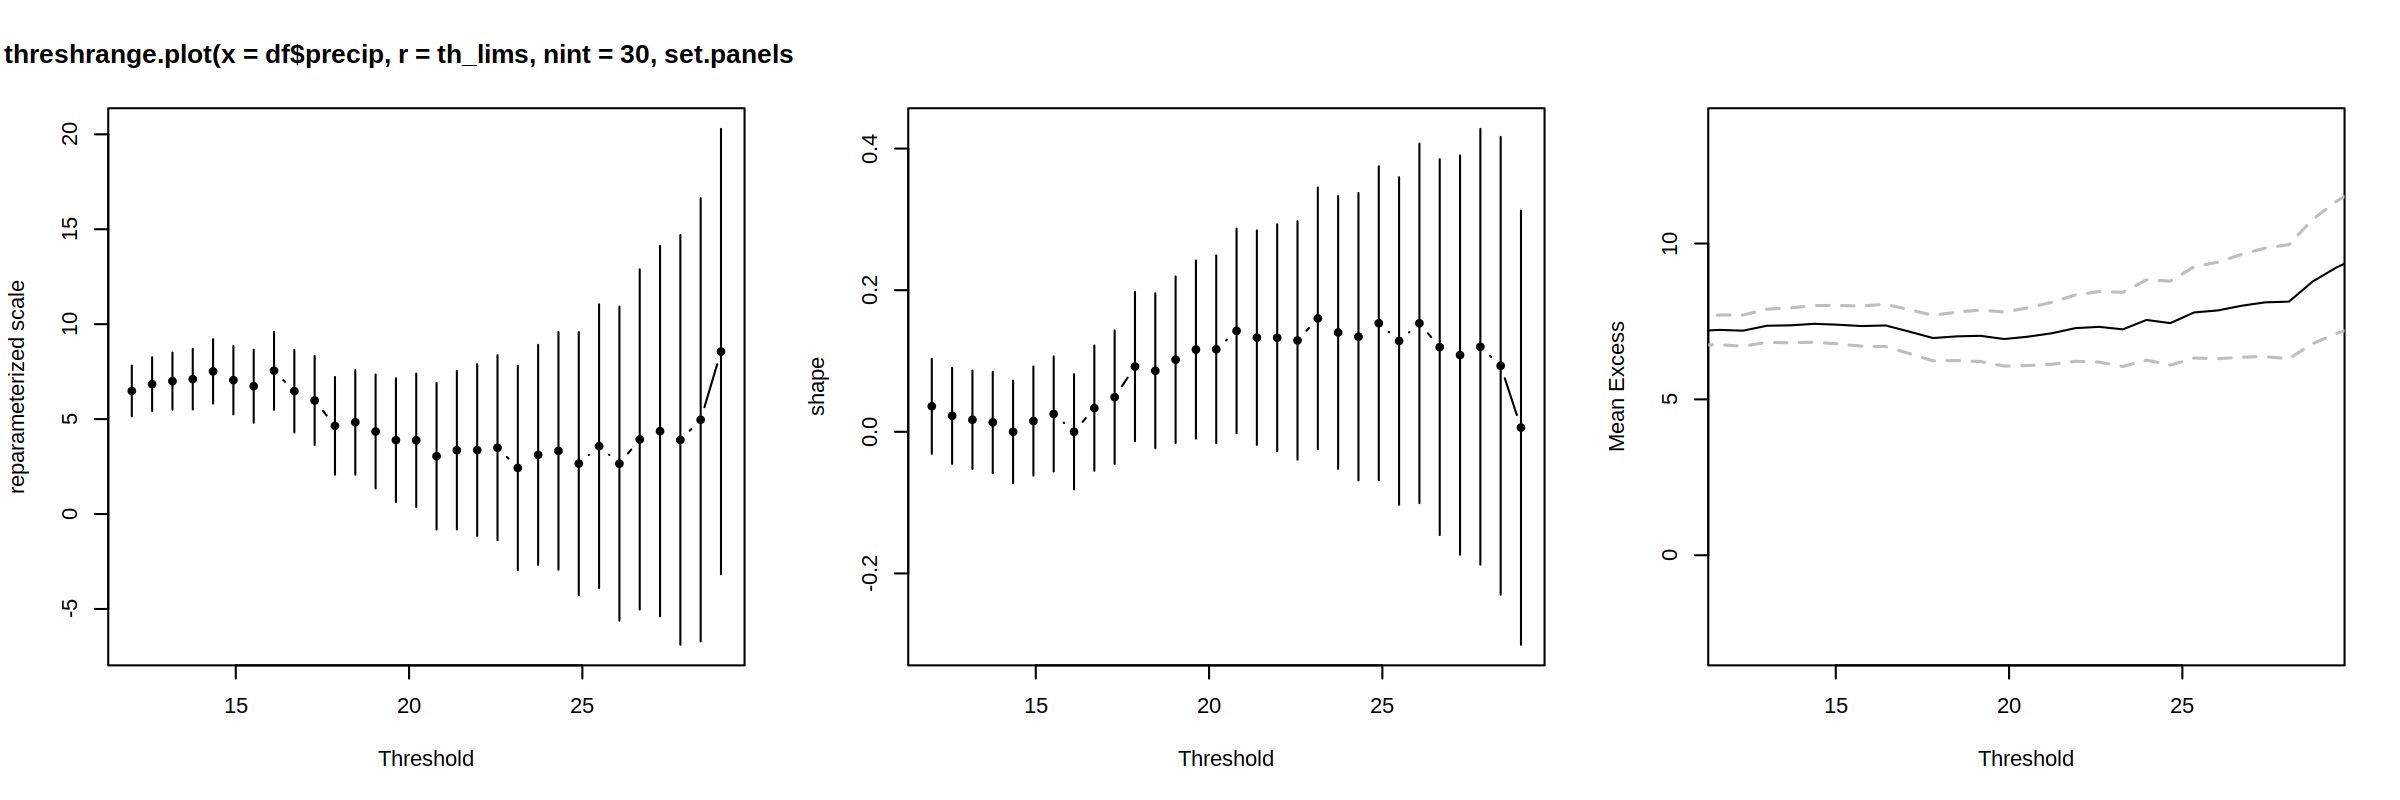

In [32]:
th_lims <- c(floor(quantile(df$precip, 0.95)), ceiling(quantile(df$precip, 0.995)))
th_lims

prep_window(c(1,3))
threshrange.plot(df$precip, th_lims, nint = 30, set.panels = F)
mrlplot(df$precip, xlim = th_lims)

# looks like anything from 20-29mm should give a pretty stable estimate (roughly q98-q99)

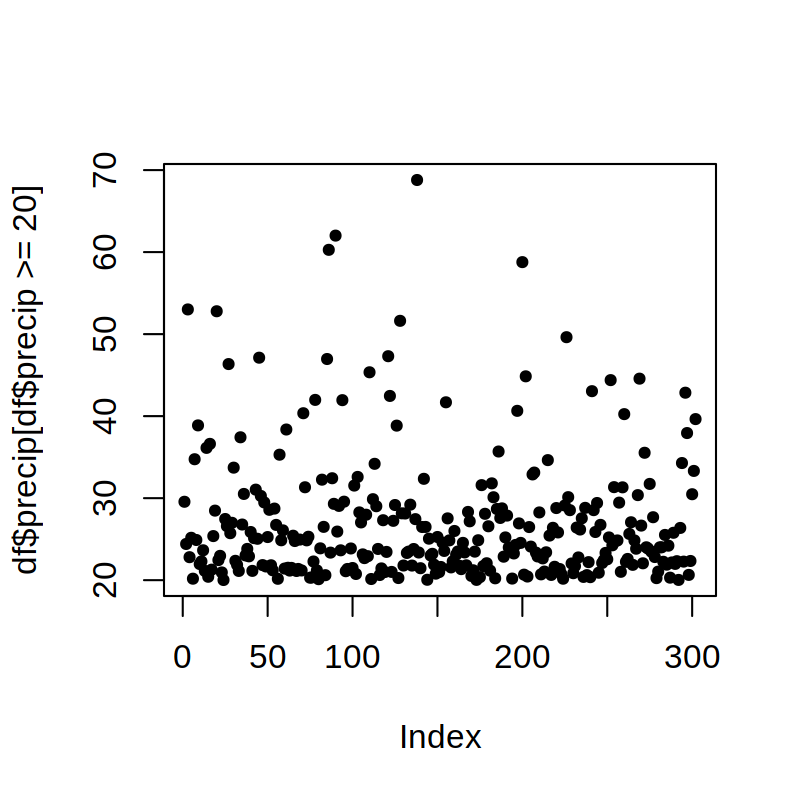

In [61]:
th <- 20
prep_window(c(1,1))
plot(df$precip[df$precip >= 20])

# doesn't really look like there's a trend

In [90]:
# stationary GPD is a pretty good fit to this data, actually
s_gpd <- fevd(precip, df, threshold = 20, type = "GP", units = "mm")
ns_gpd <- fevd(precip, df, threshold = 20, scale.fun = ~ gmst, type = "GP", units = "mm")

lr.test(s_gpd, ns_gpd)  # does not reject stationary model in favour of nonstationary


	Likelihood-ratio Test

data:  precipprecip
Likelihood-ratio = 0.63124, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.4269
alternative hypothesis: greater


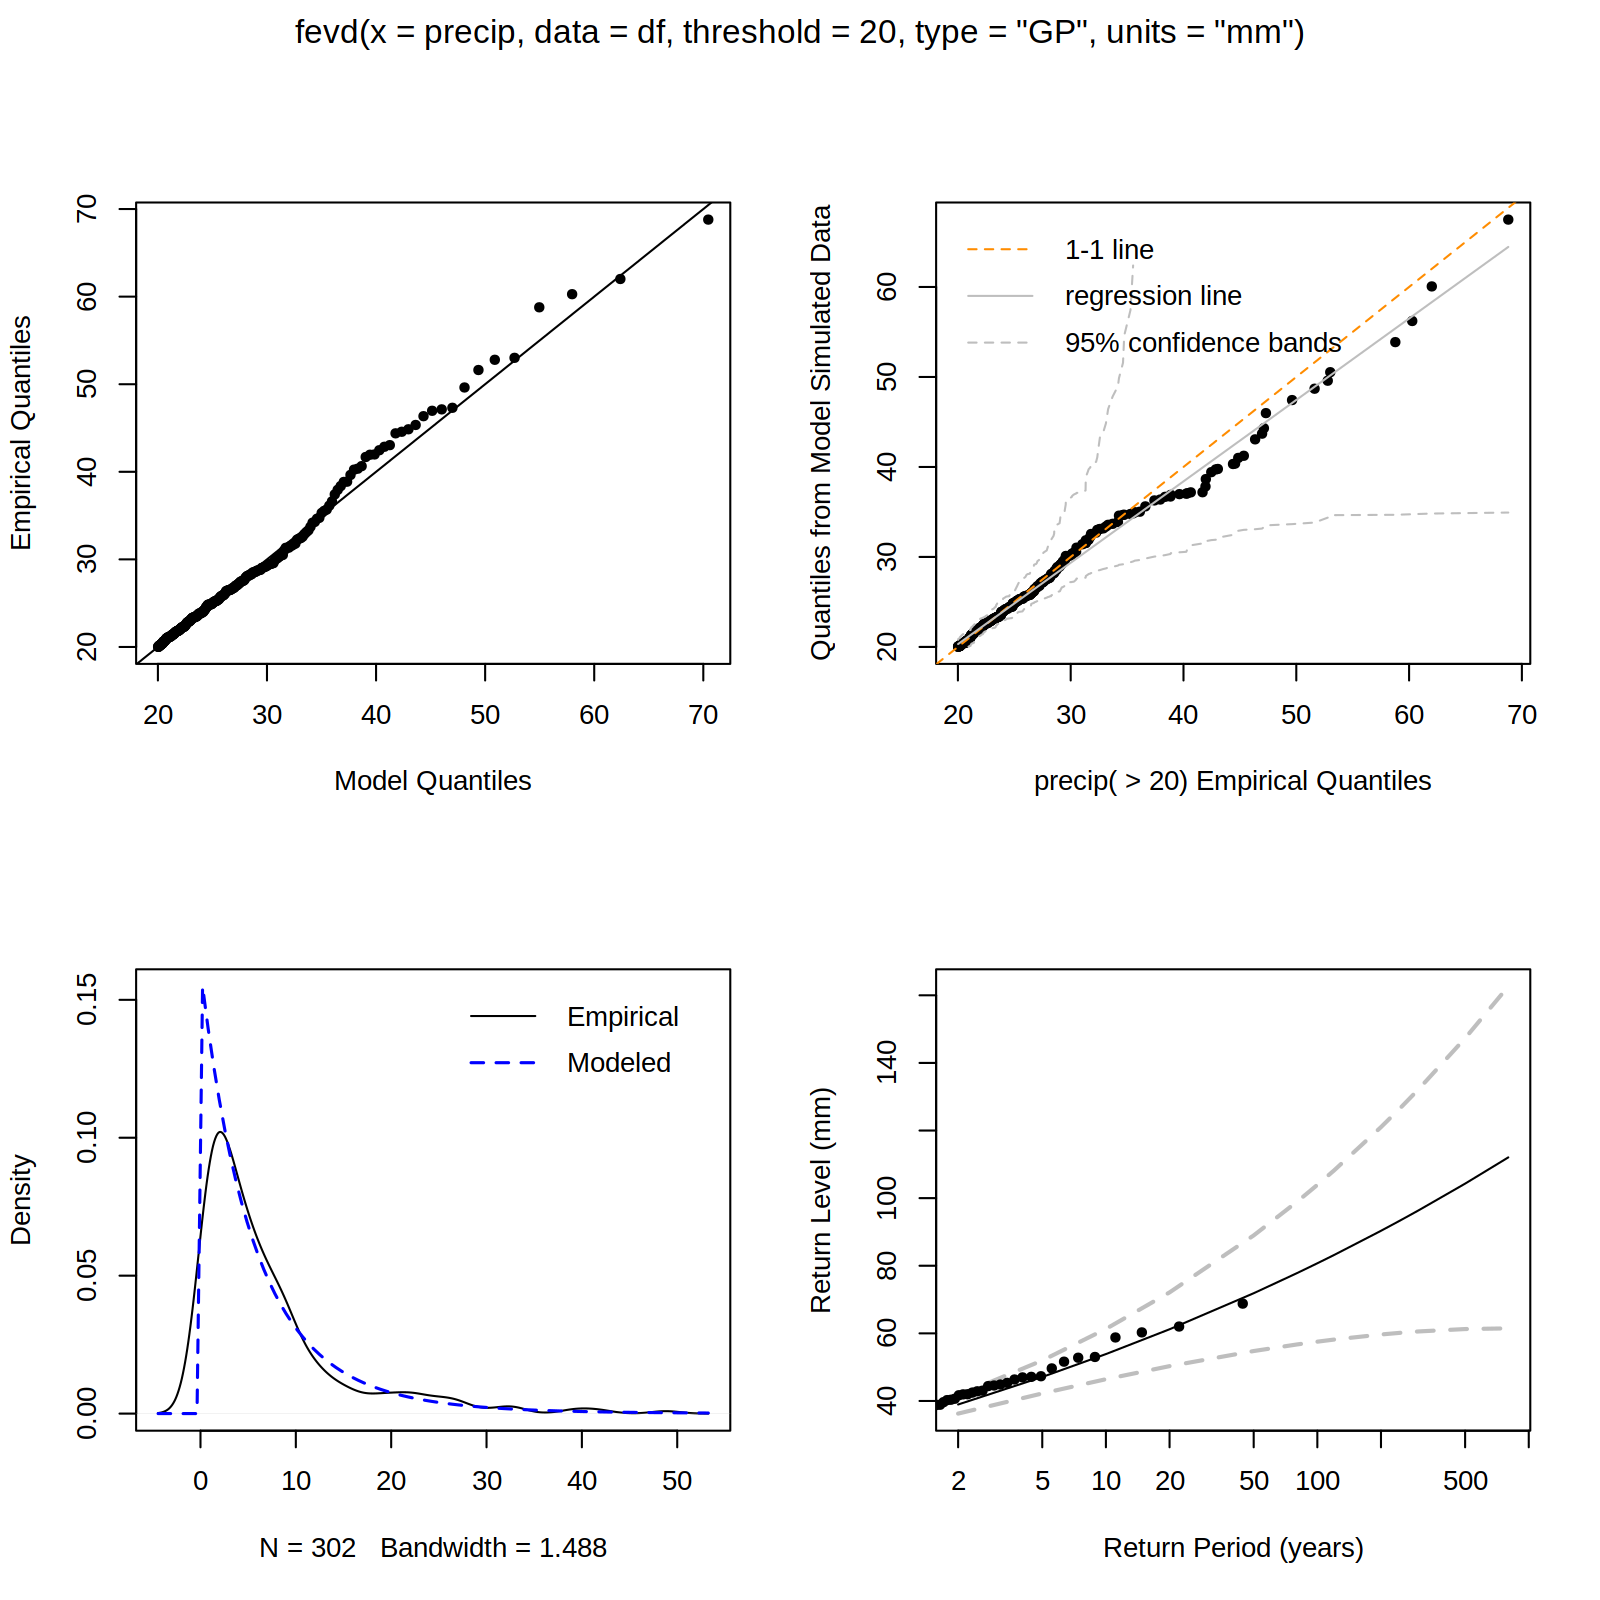

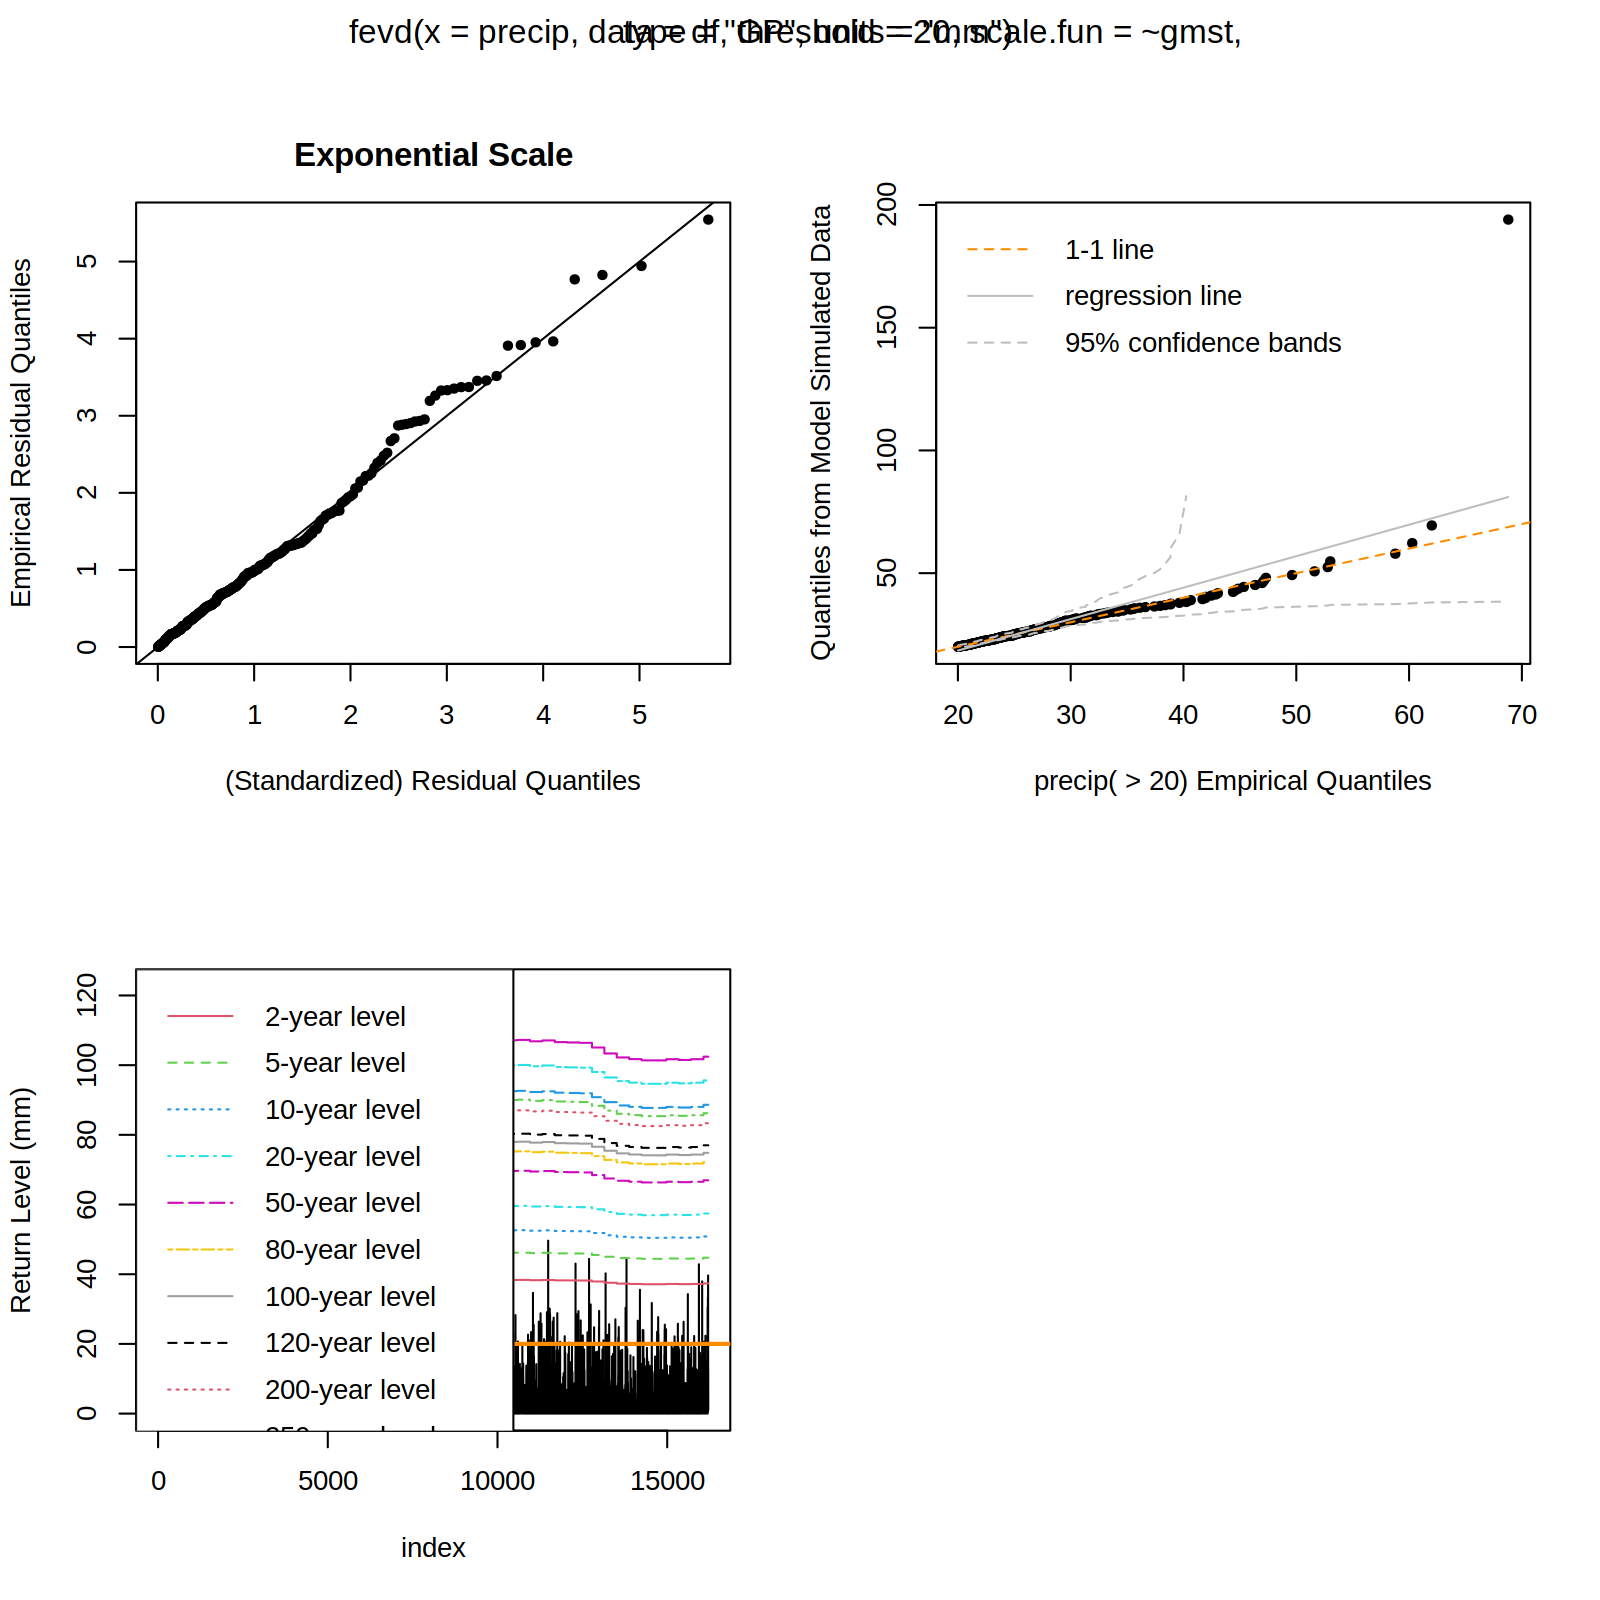

In [91]:
prep_window(c(2,2))
plot(stationary_gpd)
plot(ns_gpd)


 Data span  44.37782 years 
Setting up parameter model design matrices.
Parameter model design matrices set up.
Using Lmoments estimates as initial estimates.  Initial value = 611.5547 
Initial estimates are:
  location      scale      shape 
33.3242731  7.7737363  0.1193483 
Beginning estimation procedure.

 First fitting a GP-Poisson model in order to try to get a good initial estimate as PP likelihoods can be very unstable.
initial  value 894.665451 
final  value 888.676616 
converged

 Sticking with originally chosen initial estimates.
initial  value 611.554735 
final  value 611.553729 
converged
Time difference of 0.09199405 secs


Warning message in get(paste0("plot.", newcl))(x = x, type = type, rperiods = rperiods, :
“plot.fevd.mle: span or npy not integers; determination of max in each block may be substantially in error when there are many blocks.”


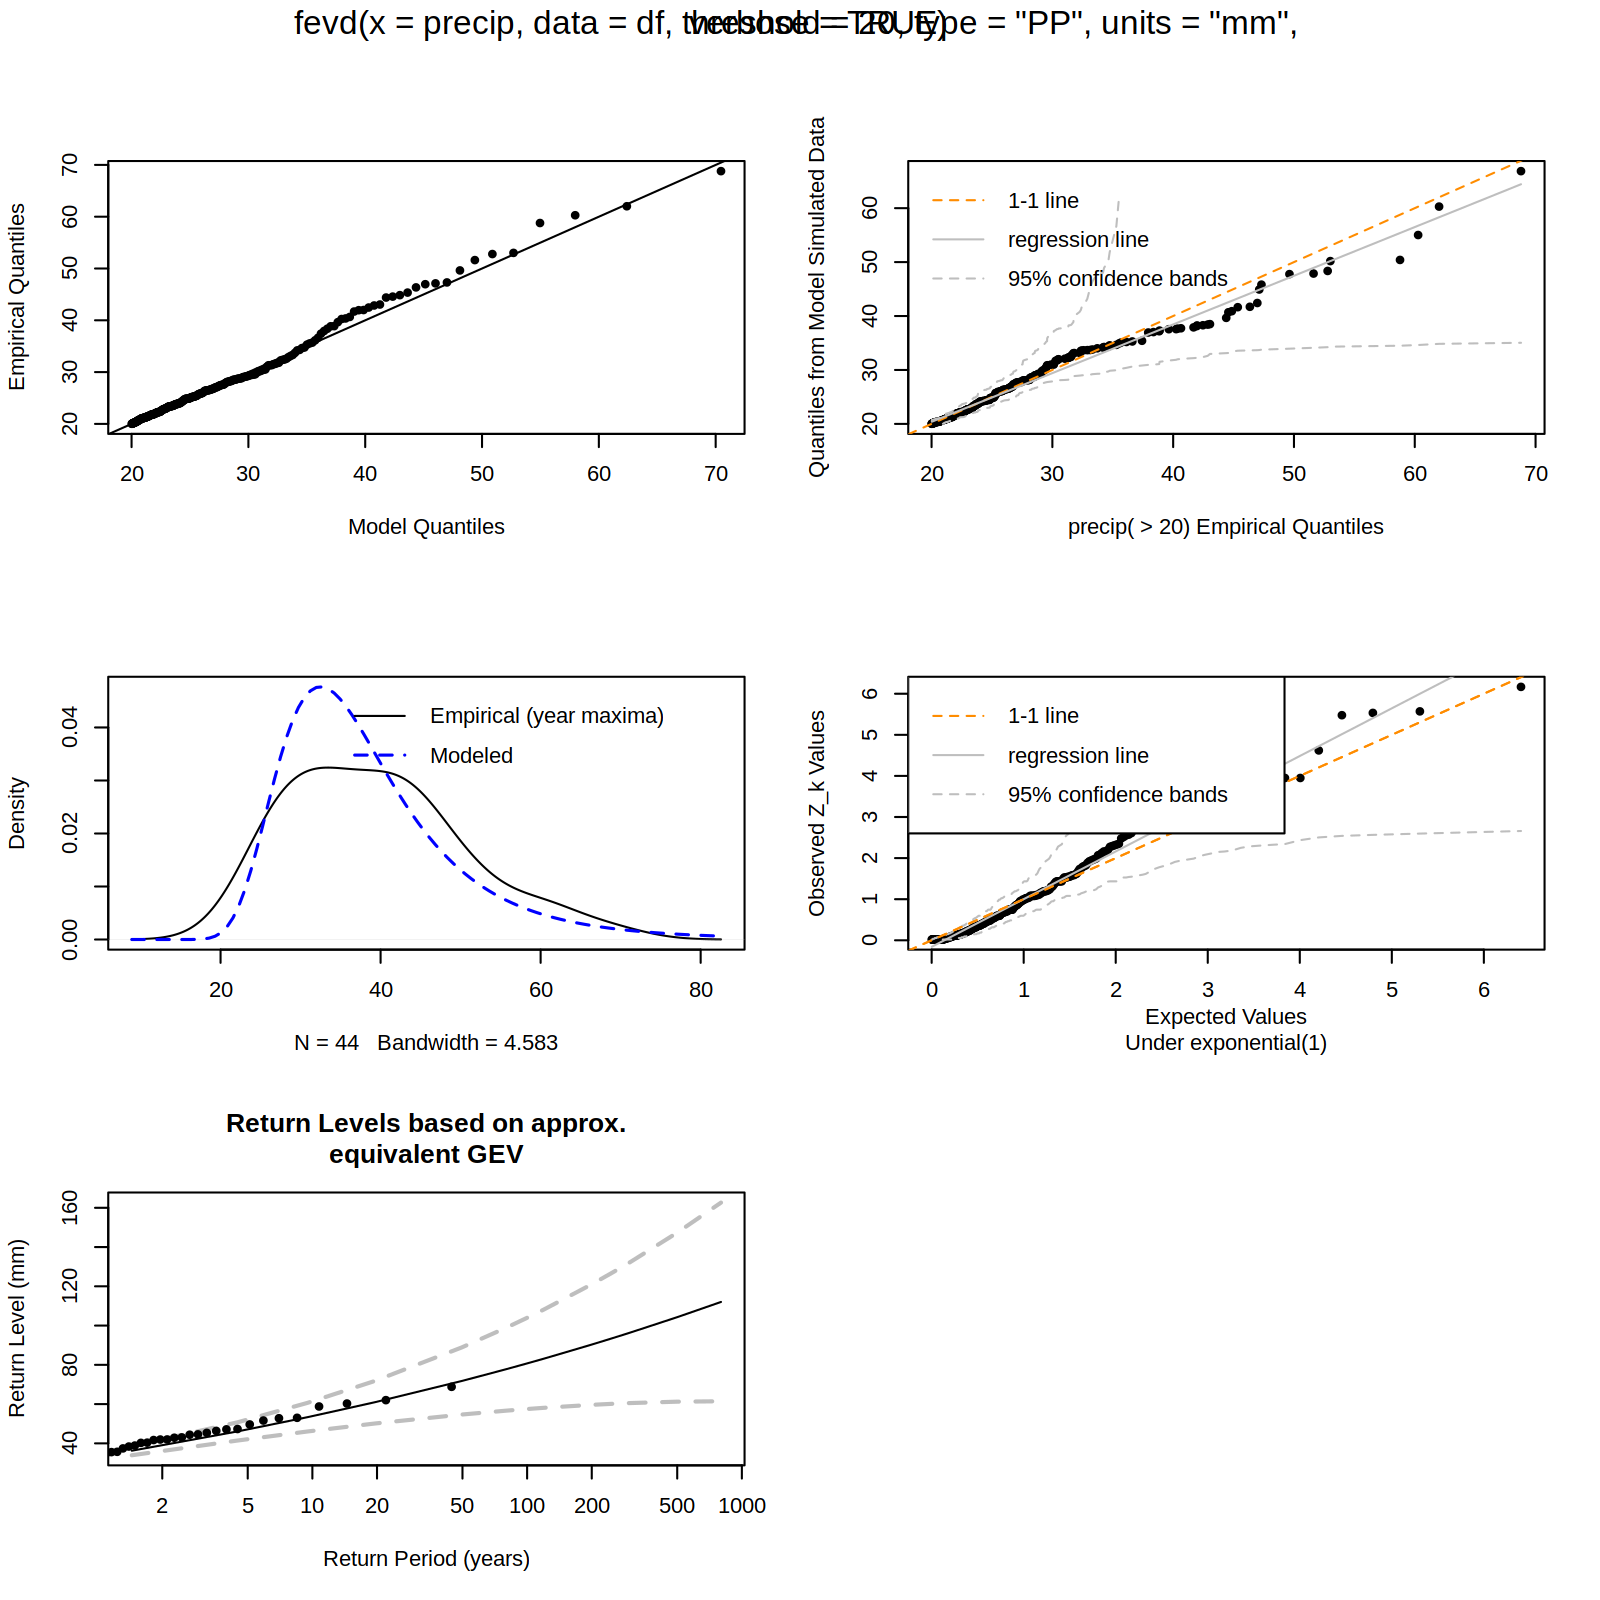

In [62]:
stationary_pp <- fevd(precip, df, threshold = 20, type = "PP", units = "mm", verbose = TRUE)

prep_window(c(2,2))
plot(stationary_pp)

### **Declustering**

In [13]:
# load MSWEP daily time series
df <- read.csv("data/mswep_emilia-romagna-ts.csv")
df$year <- substr(df$time,1,4)
df <- merge(df, load_ts("ts/Italy-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))


 Runs Estimator for the Extremal Index
    extremal.index number.of.clusters         run.length 
         0.8745875        265.0000000          1.0000000 

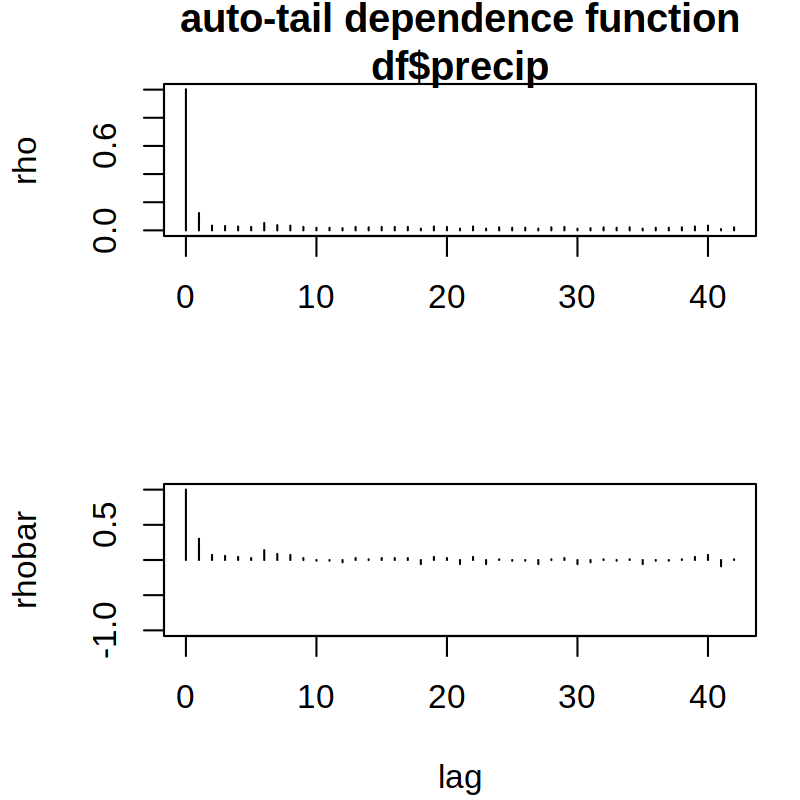

In [22]:
# very strong tail dependence
extremalindex(df$precip, 20, method = "runs")
prep_window(c(1,1))
atdf(df$precip, 0.98)

In [23]:
look <- decluster(df$precip, threshold = 20)

In [26]:
decluster(df$precip, threshold = 20, method = "intervals")


 df$precip  declustered via intervals  declustering.

 Estimated extremal index (intervals estimate) =  0.9602485 

 Number of clusters =  265 

 Run length =  3 

### **Nonstationary Poisson distribution**

In [72]:
df <- read.csv("data/mswep_emilia-romagna-ts.csv")
df$year <- substr(df$time,1,4)

gmst <- load_ts("ts/Italy-floods_gmst-smoothed.dat", col.names = c("year", "gmst"))

In [73]:
counts <- data.frame(table(df[df$precip > quantile(df$precip, 0.98), "year"]))
counts$year <- as.integer(levels(counts$Var1))

In [74]:
df <- merge(counts, gmst)

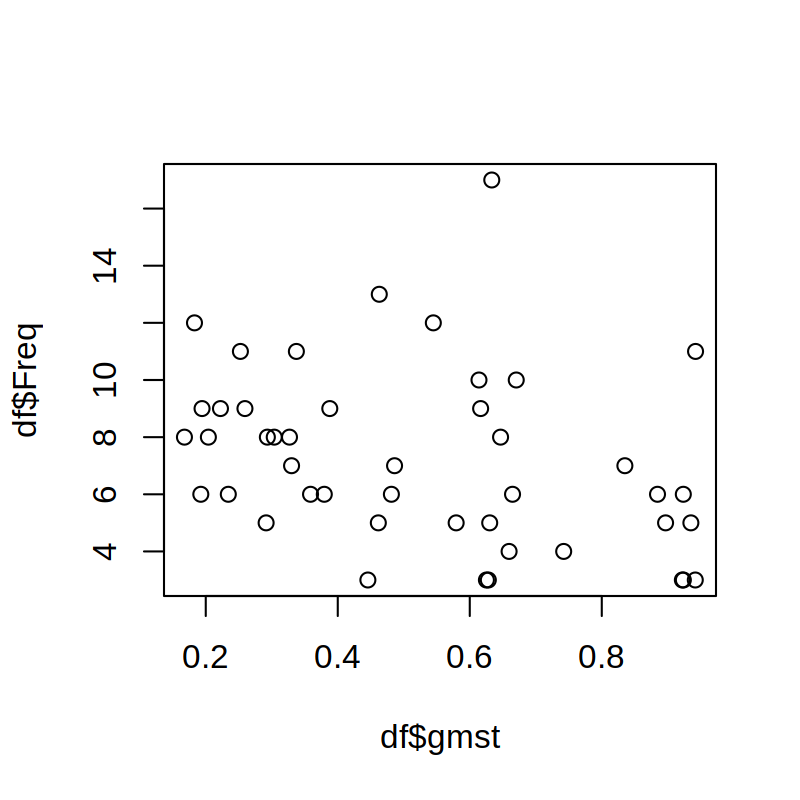

In [79]:
plot(df$gmst, df$Freq)

In [96]:
ll_pois <- function(pars = c(lam0, alpha), covariate, x) { return(-sum(dpois(x, lambda = pars["lam0"] + pars["alpha"] * covariate, log = T))) }

In [125]:
ns_pois <- optim(par = c(lam0 = mean(df$Freq), alpha = 0), ll_pois, covariate = df$gmst, x = df$Freq)
ns_pois$par["alpha"] # about 4 fewer days with precip > 20mm per degree GMST change

alpha 
-4.096873

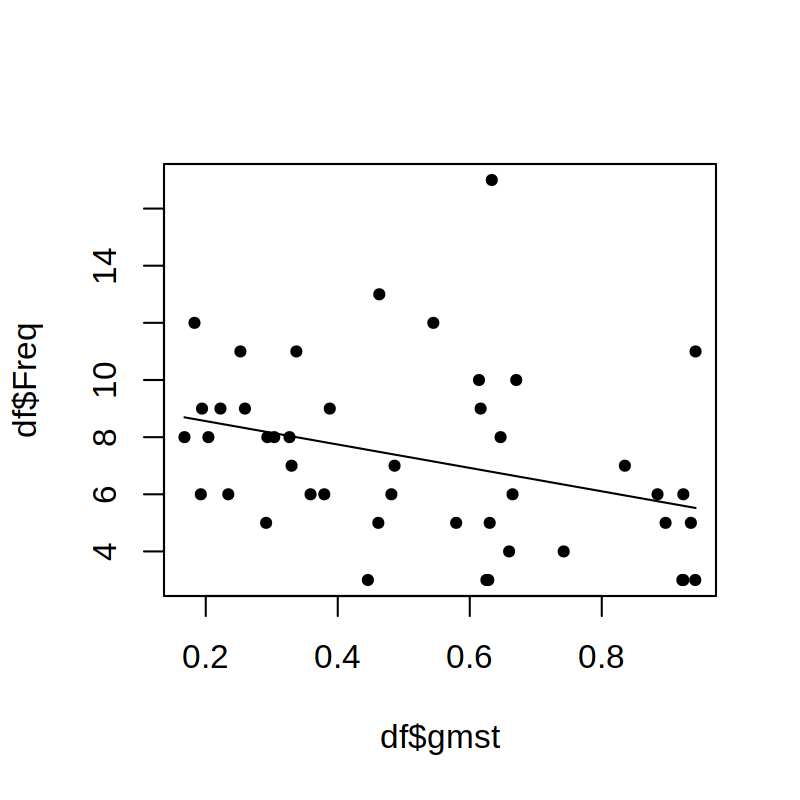

In [123]:
plot(df$gmst, df$Freq, pch = 20)
lines(df$gmst, ns_pois$par["lam0"] + df$gmst * ns_pois$par["alpha"]) # is a pretty clear trend in numbers of wet days

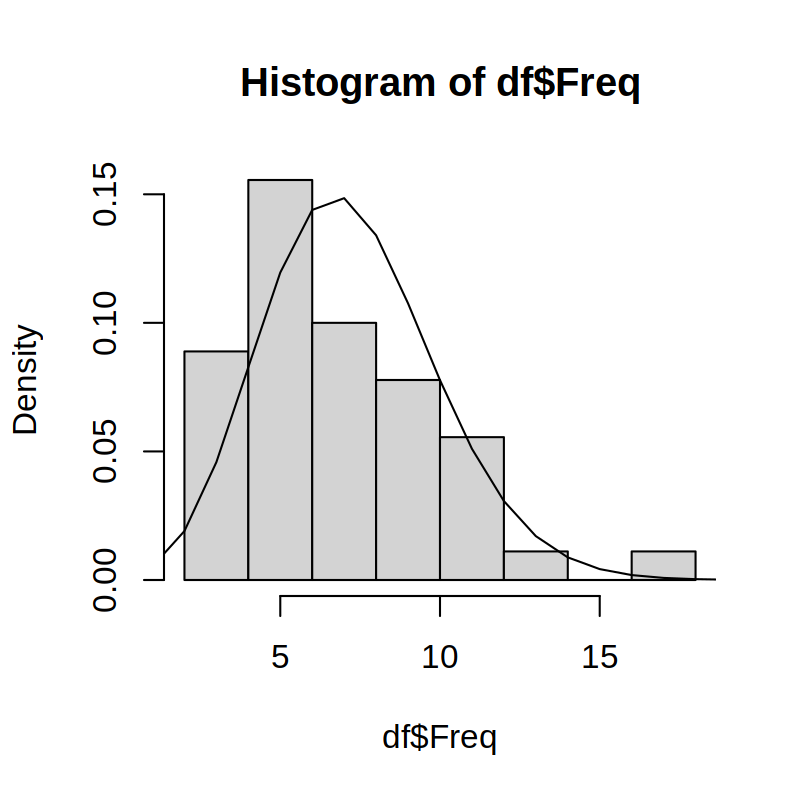

In [103]:
hist(df$Freq, prob = T)
lines(0:20, dpois(0:20, mean(df$Freq)))

# stationary fit not great.